# Read in the data

In [2]:
%matplotlib inline
import pandas
import numpy
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Create an empty dictionary and filter only the required columns in data_files
data = {}
for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d



# Read in the surveys

In [3]:
# Read in two tab-seperated files with 'windows-1252' encoding
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')

# Merge the two surveys
survey = pandas.concat([all_survey, d75_survey], axis=0)


survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return string_representation.zfill(2)
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Bar plots of correlations

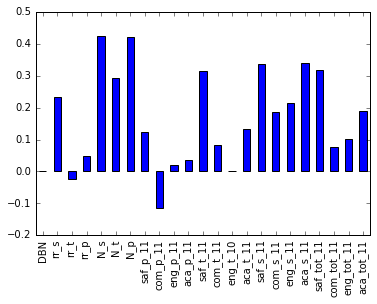

In [11]:
survey_correlation = combined.corr()["sat_score"][survey_fields].plot.bar()

There are high correlations between `N_s`,`N_t`,`N_q` with `sat_score`. This might be due to high number of respondents mean that the total enrollment is also very high, which correlates with SAT score.

Interestingly, `saf_t` and `saf_s` both have high correlation with `sat_score`. This might be relevant because high concern for safety and respect indicates that the educational institution has a conducive learning environment which might boosts performance in sat exams.

`com_s` and `com_t` also have quite high correlations which makes sense since engagement and communication also have impacts on student academic performance.

`rr_s` which refers to student response rate makes sense since those who did well in the exam tend to respond to such surveys.

# Investigate satefy and sat scores

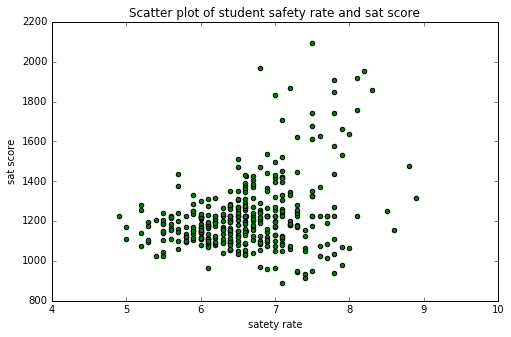

In [12]:
fig,ax = plt.subplots(figsize = (8,5))
ax.scatter(combined['saf_s_11'],combined['sat_score'],c='green')
ax.set_title('Scatter plot of student safety rate and sat score')
ax.set_xlabel('satety rate')
ax.set_ylabel('sat score')

There appears to be a positive relationship between satety score and sat score. However, the relationship does not seem to be linear. There is a cluster of points centered at sat score of 1200 and safety rate between 5 and 7.

# Plot satefy

NameError: name 'latitudes' is not defined

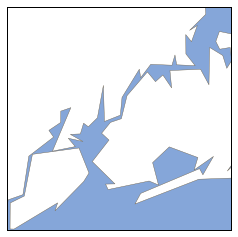

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Find the average for each column by school districts
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

# Plot the basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
# Temporary bug: if you run the following line of code in the Jupyter Guided Project interface on Dataquest, you'll get an error. 
# We're working on a fix, thanks for your patience! This should work fine locally on your own computer though.
m.fillcontinents(color='white',lake_color='#85A6D9')

# convert the lon and lat to list and then plot school districts using safety rate as the color
longitudes = districts['lon'].tolist()
lalitudes = districts['lat'].tolist()
m.scatter(longitudes,latitudes,zorder=2,latlon=True,s=50,c=districts['saf_s_11'],cmap='summer')

It looks like Bronx and Upper Manhattan have low satefy rate where Brooklyn has high safety rate.

# Plotting race percentage against sat score

In [ ]:
race = ['white_per','asian_per','black_per','hispanic_per']
race_corr = combined.corr()['sat_score'][race].plot.bar()

From the bar plots above, we notice that high percentage of white and asian have high correlation with sat scores whereas black and hispanic persentage have negative correlation with sat scores.

In [ ]:
plt.scatter(combined['hispanic_per'],combined['sat_score'],c='red')

From the scatter plot we can see there is a downward relationship between sat score and percentage of hispanic students

In [ ]:
print(combined[combined['hispanic_per'] > 95]['SCHOOL NAME'])

Majority of the schools are community college

In [ ]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

These are specialized science and technology schools

# Gender Percentage and Sat Score

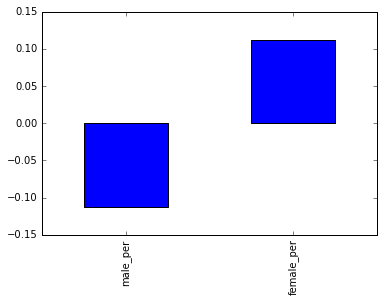

In [16]:
gender = ['male_per','female_per']
combined.corr()['sat_score'][gender].plot.bar()

It appears that male percentage has a negative correlation means that higher male percentage leads to decrease in sat score

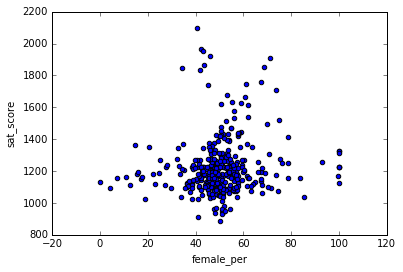

In [17]:
# Scatter Plot
combined.plot.scatter('female_per','sat_score')

There does not seem to be a very strong linear relationship between female percentage and sat score. Points tend to be scrambling around enter at sat score of 1200 and female percentage between 40 and 60.

In [19]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools have very high academic standard and are very selective of the students they bring in

# AP and Sat Score

In [20]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

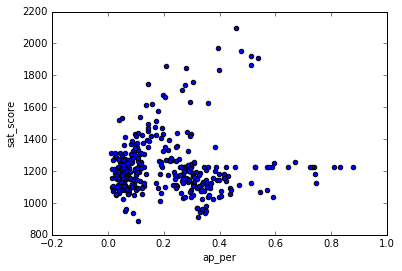

In [21]:
combined.plot.scatter('ap_per','sat_score')

For some schools, there appears to be a positive correlation between ap test percentage and sat score.

# Class size

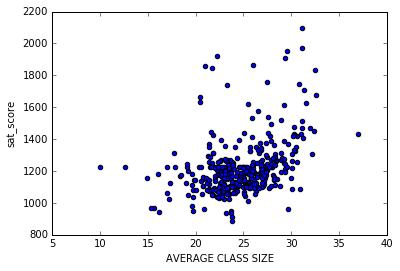

In [53]:
list(combined.columns.values)
combined.plot.scatter('AVERAGE CLASS SIZE','sat_score')

There appears to be a postive relationship between average class size and sat scores.